***DOWNLOADING AND LOADING CIFAR-10***

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define transformations: Convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images between -1 and 1
])

# Download and load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders for batch processing
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False)

# CIFAR-10 class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("CIFAR-10 Dataset Downloaded and Loaded Successfully!")


Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 Dataset Downloaded and Loaded Successfully!


***Display Sample Images from CIFAR-10***

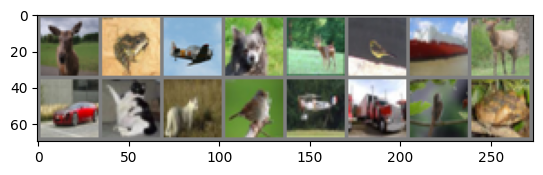

Labels: ['deer', 'frog', 'plane', 'dog', 'deer', 'bird', 'ship', 'deer', 'car', 'cat', 'cat', 'bird', 'plane', 'truck', 'bird', 'frog']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize to get original colors
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert (C, H, W) to (H, W, C)
    plt.show()

# Get random images from dataset
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Display images
imshow(torchvision.utils.make_grid(images))

# Print class labels
print("Labels:", [classes[labels[j]] for j in range(16)])


***Define the Neural Network Architecture***

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Define the Feedforward Neural Network
class CIFAR10_NeuralNetwork(nn.Module):
    def __init__(self, hidden_layers=[128, 256, 512], activation='relu'):
        super(CIFAR10_NeuralNetwork, self).__init__()

        # Input layer (3 color channels, 32x32 pixels)
        self.fc1 = nn.Linear(3 * 32 * 32, hidden_layers[0])
        self.fc2 = nn.Linear(hidden_layers[0], hidden_layers[1])
        self.fc3 = nn.Linear(hidden_layers[1], hidden_layers[2])
        self.fc4 = nn.Linear(hidden_layers[2], 10)  # Output layer (10 classes)

        # Choose activation function
        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)  # Flatten the image to 1D vector
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)  # No activation in output layer (logits)
        return x

print(" Neural Network Defined Successfully!")


 Neural Network Defined Successfully!


***Train the Neural Network,Initialize Model, Loss Function, and Optimizer***

In [ ]:
import torch.optim as optim

# Initialize model
model = CIFAR10_NeuralNetwork()

# Define Loss Function (Cross-Entropy Loss for Classification)
criterion = nn.CrossEntropyLoss()

# Define Optimizer (Adam Optimizer with learning rate 0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(" Model Initialized and Ready for Training!")


 Model Initialized and Ready for Training!


***Train the Model , Run this to train the model for 5 epochs:***

In [ ]:
num_epochs = 5  # Number of training iterations

for epoch in range(num_epochs):
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available

        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}")

print("Training Completed!")


Epoch [1/5], Loss: 1.6875
Epoch [2/5], Loss: 1.4918
Epoch [3/5], Loss: 1.3932
Epoch [4/5], Loss: 1.3271
Epoch [5/5], Loss: 1.2695
Training Completed!


***EVALUATE MODEL ACCURACY***

In [ ]:
correct = 0
total = 0
model.eval()

cross_entropy_loss = 0.0  # Store CE loss
mse_loss = 0.0  # Store MSE loss

mse_criterion = nn.MSELoss()  # Define Squared Error Loss (MSELoss)
ce_criterion = nn.CrossEntropyLoss()  # Already defined in your code

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        # Compute Cross-Entropy Loss
        cross_entropy_loss += ce_criterion(outputs, labels).item()

        # Convert labels to one-hot for MSE Loss
        labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=10).float()
        mse_loss += mse_criterion(outputs, labels_one_hot).item()

        # Accuracy Calculation
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute final accuracy and loss
accuracy = 100 * correct / total
print(f"Model Accuracy on Test Set: {accuracy:.2f}%")
print(f"Cross-Entropy Loss on Test Set: {cross_entropy_loss / len(testloader):.4f}")
print(f"Mean Squared Error Loss on Test Set: {mse_loss / len(testloader):.4f}")


Model Accuracy on Test Set: 50.85%
Cross-Entropy Loss on Test Set: 1.4042
Mean Squared Error Loss on Test Set: 9.7332


***PLOT CONFUSION MATRIX RUNNING IT TO VISUALISE THE CONFUSION MATRIX***

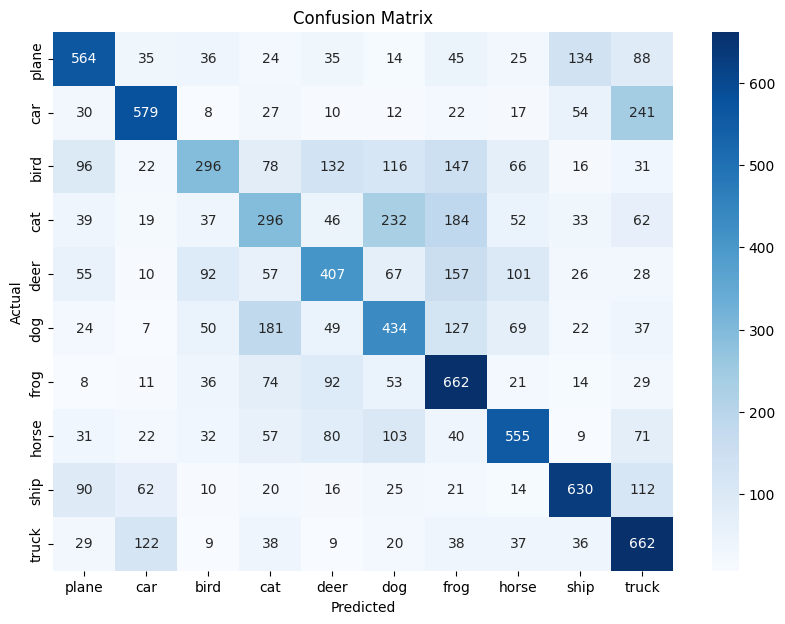

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true and predicted labels
true_labels = []
pred_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


***TRAINING WITH DIFFERENT HYPERPARAMETERS TO TRY DIFFERENT CONFIGURATIONS***

In [ ]:
# Define hyperparameters to experiment with
hyperparameter_configs = [
    {"hidden_layers": [64, 128, 256], "learning_rate": 0.001, "batch_size": 32, "optimizer": "adam"},
    {"hidden_layers": [128, 256, 512], "learning_rate": 0.0005, "batch_size": 64, "optimizer": "sgd"},
    {"hidden_layers": [32, 64, 128], "learning_rate": 0.001, "batch_size": 16, "optimizer": "rmsprop"}
]

# Function to train and evaluate with different hyperparameters
def train_and_evaluate(config):
    print(f"\nTraining with: {config}")

    # Initialize model with specific hidden layers
    model = CIFAR10_NeuralNetwork(hidden_layers=config["hidden_layers"]).to(device)
    criterion = nn.CrossEntropyLoss()

    # Select optimizer
    if config["optimizer"] == "adam":
        optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    elif config["optimizer"] == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=config["learning_rate"], momentum=0.9)
    elif config["optimizer"] == "rmsprop":
        optimizer = optim.RMSprop(model.parameters(), lr=config["learning_rate"])

    # Update batch size in DataLoader
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=config["batch_size"], shuffle=True)

    # Train the model
    for epoch in range(3):  # Train for 3 epochs per config
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/3], Loss: {running_loss / len(trainloader):.4f}")

    # Evaluate accuracy
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

# Run experiments with different configurations
best_accuracy = 0
best_config = None
for config in hyperparameter_configs:
    acc = train_and_evaluate(config)
    if acc > best_accuracy:
        best_accuracy = acc
        best_config = config

print(f"\n Best Configuration: {best_config} with Accuracy: {best_accuracy:.2f}%")



Training with: {'hidden_layers': [64, 128, 256], 'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam'}
Epoch [1/3], Loss: 1.6709
Epoch [2/3], Loss: 1.4741
Epoch [3/3], Loss: 1.3808
Accuracy: 49.60%

Training with: {'hidden_layers': [128, 256, 512], 'learning_rate': 0.0005, 'batch_size': 64, 'optimizer': 'sgd'}
Epoch [1/3], Loss: 2.2594
Epoch [2/3], Loss: 2.0697
Epoch [3/3], Loss: 1.9194
Accuracy: 33.68%

Training with: {'hidden_layers': [32, 64, 128], 'learning_rate': 0.001, 'batch_size': 16, 'optimizer': 'rmsprop'}
Epoch [1/3], Loss: 1.6914
Epoch [2/3], Loss: 1.5258
Epoch [3/3], Loss: 1.4634
Accuracy: 46.34%

 Best Configuration: {'hidden_layers': [64, 128, 256], 'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam'} with Accuracy: 49.60%
